In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import util.utilities

import learning

from importlib import reload

In [2]:
from sklearn.datasets import make_circles, make_blobs

In [15]:
reload(util.utilities)

<module 'util.utilities' from 'F:\\Coding\\data-science\\fastai\\neural-net-experiments\\util\\utilities.py'>

## Birds Eye PyTorch

In its simplest form, a neural network is just a function which takes in values, uses a bunch of numerical weights which are updated using gradient descent to reduce loss, and produces a number from the inputs.

Here, we see a very simple neural network which takes in a linear array of x values and tries to approximate the y value of each based. In this case the labels are the actual Y values of a sine wave function, and the loss function is just MSE, showing how far each point is from the actual sine wave point.

As far as pytorch is concerned, a dataset is just any value which returns a tuple of (image, label) given an index. Note that the dataset is a tuple of 2d tensors. The first tensor is the list of inputs and the second array is the list of outputs. A DataLoader is just taking that dataset and splitting it into batches. Here, we ignore validation and training sets for simplicity.

In this case, we have only 1 input value and 1 output value, so we have to unsqueeze the tensor.

In words, what we're doing here is telling the computer:
* Here's a list of x values, try to predict the y values based on how close I indicate you are from the actual value we're looking for (the label)
* For each batch of data, based on the derivative of the loss function (the gradient), adjust the weights in the direction, and by the magnitude, indicated by the gradient. The learning rate also determines the magnitude of the adjustment. If learning rate is too high for the given model, **the loss can quickly become so high that it overflows the integer container**. If this happens, the divergence is usually unrecoverable (diverges further each time). In that case, we must reduce the learning rate.
* There are a ton of ways to improve the final loss here, including just setting epochs super high. Will need to figure out a way to figure the best options here eventually.
* After a number of **epochs** (full passes through the dataset), our model creates a set of weights which best approximate our target function.

This is effectively a **regression** dataset, since we're predicting a y coordinate based on an x coordinate.

Output()

Final loss: 0.2089529595687054

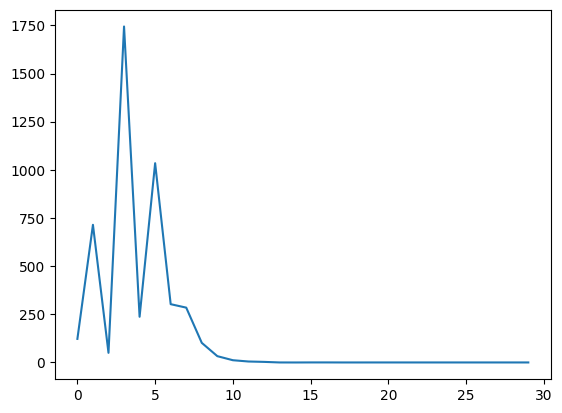

In [10]:
torch.manual_seed(42)

# Simple -5 to 5 range with 100 steps
X = torch.linspace(-5, 5, 100)
# Create a simple sine wave as our target for prediction
y = torch.sin(X)

# Datasets need to be in the form of 1 array per dataset. Since we only have 1 value per, just unsqueeze.
# Unsqueeze takes single values [1,2,3] and makes them have 1 row each [[1], [2]. [3]], which is what we need
dataset = list(zip(X.unsqueeze(1), y.unsqueeze(1)))

# A simple model
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1)
).to("cuda")

# More complex, harder to tune learn rate, etc. Probably would end up better with more tweaks?
# model = torch.nn.Sequential(
#     torch.nn.Linear(1, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 100),
#     torch.nn.ReLU(),
#     torch.nn.Linear(100, 1),
# ).to("cuda")

epochs = 30

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# Higher learning rates better for more complex model
# optimizer = torch.optim.SGD(model.parameters(), lr=0.08)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.04, steps_per_epoch=len(dataset), epochs=epochs
# )
scheduler = None

# I wrote this learner. Learners are very abstractable. In nutshell, all it does is:
# For each batch, feed it into the model to get preds. 
# Using a loss function, get the loss on the preds vs. the labels. 
# Adjust parameters/weights based on the gradient of loss func and learning rate 
#   (with, e.g. stochastic gradient descent, but others possible).
learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        torch.utils.data.DataLoader(dataset, batch_size=10), 
        torch.utils.data.DataLoader(dataset, batch_size=10),
        torch.utils.data.DataLoader(dataset, batch_size=10)
    ),
    model=model,
    loss_function=torch.nn.MSELoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device="cuda"
    # device="cpu"
)
learner.train_model(epochs)
learner.plot_epoch_data()

The final epoch's loss can be displayed visually by graphing the original sine wave alongside a single full forward pass of the x data to the model.

In essense, we're saying, hey model, based on the weights you've learned, go ahead and make 1 prediction for every input value. Then, we graph this.

The lower the final loss, the closer the graph ends up to the target.

We've basically emulated a "sine wave" mathematical function, without knowing that we were estimating a sine wave. The resulting function is a bunch of linear weights and biases with a nonlinear function in between.

Normally, we can graph several individual samples along with their labels to visualize the same thing. But since we have just a simple linear function, we can just plot the whole thing.

mse: 0.20895297825336456


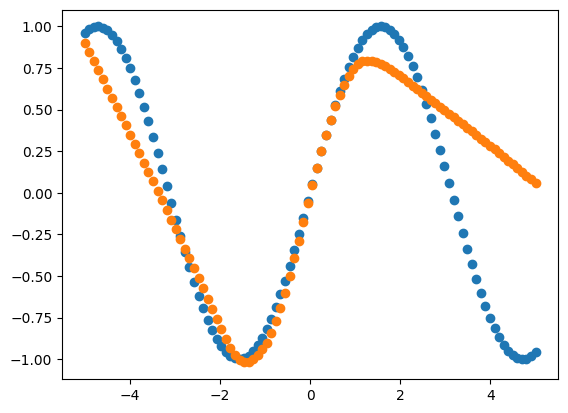

In [12]:
with torch.inference_mode():
    y_preds = model(X.unsqueeze(1).to("cuda"))
    
print(f"mse: {torch.nn.MSELoss()(y_preds, y.unsqueeze(1).to('cuda'))}")
plt.scatter(x=X, y=y)
plt.scatter(x=X, y=y_preds.cpu())

## Classification Dataset

This is a **completely** different dataset than the prior one (X is now x,y coords rather than just x coord to predict y coord), and even a different type of problem (classification - instead of predicting a y coordinate, we're predicting whether an x,y coord is label 0 or 1).

But because of the flexibility of neural networks, the **only** changes we needed to make were:
* Adjust reshaping of input (X)
* Adjust the input param number in the first linear layer (Linear(1, 1000) to Linear(2, 1000) to account for new input shape
* Change loss function to account for different problem (MSE to BCE)

Everything else is the same (also adjusted learning rate since it worked better with higher rate). And the results are a model with almost perfect predictive power (classifies whether each dot is in 1 class or the other, as shown in the plotted decision boundry).

⠏ Epochs     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━  95% 0:00:02 0:00:27 19 / 20 0.0773 loss
⠏ Validating ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━  92% 0:00:01 0:00:00 1113.04 items/sec 0.05 loss
            Epochs             
┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Epoch ┃ Loss     ┃ Accuracy ┃
┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 10    │ 0.148805 │ 100.0%   │
│ 11    │ 0.135474 │ 100.0%   │
│ 12    │ 0.124239 │ 100.0%   │
│ 13    │ 0.114668 │ 100.0%   │
│ 14    │ 0.106368 │ 100.0%   │
│ 15    │ 0.099092 │ 100.0%   │
│ 16    │ 0.092686 │ 100.0%   │
│ 17    │ 0.086999 │ 100.0%   │
│ 18    │ 0.081911 │ 100.0%   │
│ 19    │ 0.077341 │ 100.0%   │
└───────┴──────────┴──────────┘

Final loss: 0.07322159379720689

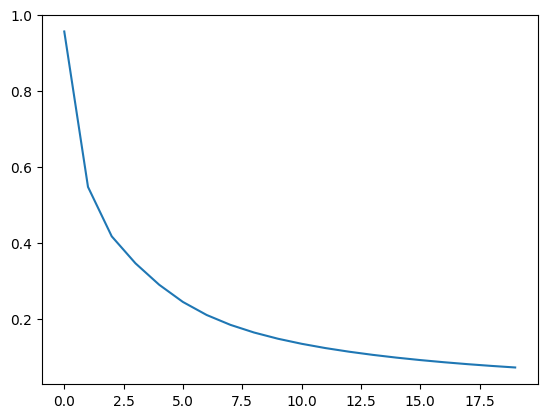

In [19]:
# Simple classification dataset with 2 colors dots in 2 circles
circles = make_circles(n_samples=500, noise=0.026)
# x, y coords
circles_X = circles[0]
# Labels
circles_y = circles[1]

# Already a 2d array, don't need to unsqueeze X
X = torch.from_numpy(circles_X).type(torch.float)
y = torch.from_numpy(circles_y).type(torch.float).unsqueeze(1)

dataset = list(zip(X, y))

# A simple model
model = torch.nn.Sequential(
    torch.nn.Linear(2, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1)
).to("cuda")

epochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = None

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        torch.utils.data.DataLoader(dataset, batch_size=10), 
        torch.utils.data.DataLoader(dataset, batch_size=10),
        torch.utils.data.DataLoader(dataset, batch_size=10)
    ),
    model=model,
    loss_function=torch.nn.BCEWithLogitsLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device="cuda"
    # device="cpu"
)
learner.train_model(epochs)
learner.plot_epoch_data()

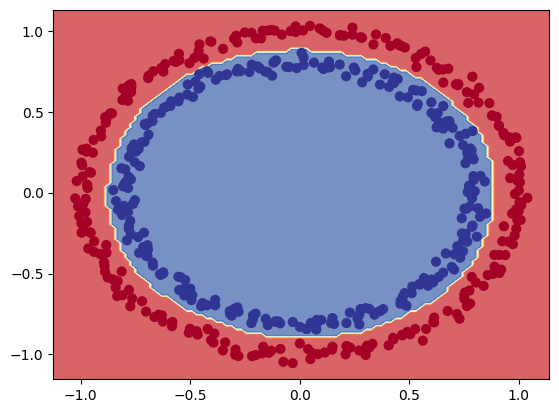

In [21]:
util.utilities.plot_decision_boundary(model, X, y)

## Multiclassification

To make this capable of doing multiclass prediction, just a couple of chnages are needed again, pretty much the same ones as before.
* Adjust reshaping of output this time (y)* Adjust the output param of the last layer to accomidate number of classese* 
Change loss function to account for different problemo B to cross entropy lossC)


⠏ Epochs     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━━━━  80% 0:00:01 0:00:04 4 / 5 0.1659 loss
⠏ Validating ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━  94% 0:00:01 0:00:00 2198.3 items/sec -0.0 loss
            Epochs             
┏━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃ Epoch ┃ Loss     ┃ Accuracy ┃
┡━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━┩
│ 1     │ 0.295239 │ 99.2%    │
│ 2     │ 0.186416 │ 99.2%    │
│ 3     │ 0.178008 │ 99.0%    │
│ 4     │ 0.165862 │ 98.9%    │
└───────┴──────────┴──────────┘

Final loss: 0.16296767868311135

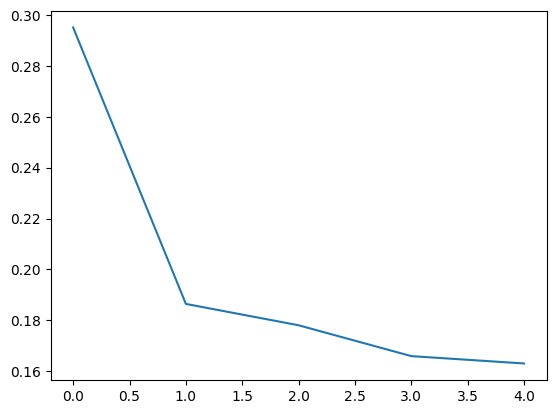

In [19]:
# Simple classification dataset with 4 colors of dots in clusters
num_classes = 4
# Just the dimensionality (x, y) coords, so 2 dims
num_features = 2
blobs = make_blobs(
    n_samples=1000, 
    n_features=num_features, 
    centers=num_classes, 
    cluster_std=1.5, 
    random_state=42)
# x, y coords
blobs_X = blobs[0]
# Labels
blobs_y = blobs[1]

# Already a 2d array, don't need to unsqueeze X
X = torch.from_numpy(blobs_X).type(torch.float)
# Since we are outputting 4 classes, we need to one-hot encode the label integer
y = torch.nn.functional.one_hot(
    # One hot requires an int64
    torch.from_numpy(blobs_y).type(torch.int64),
    num_classes=num_classes
# But output requires a float
).type(torch.float)


dataset = list(zip(X, y))

# A simple model
model = torch.nn.Sequential(
    torch.nn.Linear(num_features, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, num_classes)
).to("cuda")

epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = None

learner = learning.Learner(
    data_loaders=learning.DataLoaders(
        torch.utils.data.DataLoader(dataset, batch_size=10), 
        torch.utils.data.DataLoader(dataset, batch_size=10),
        torch.utils.data.DataLoader(dataset, batch_size=10)
    ),
    model=model,
    loss_function=torch.nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    device="cuda"
    # device="cpu"
)
learner.train_model(epochs)
learner.plot_epoch_data()

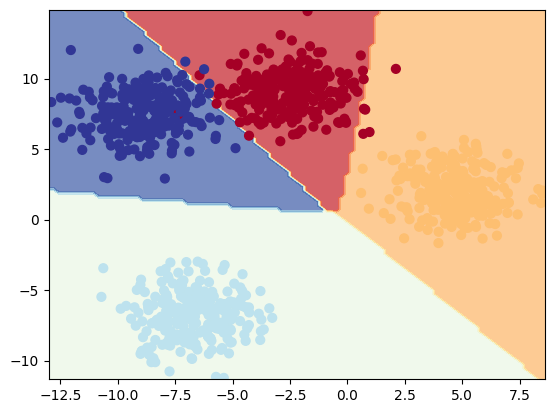

In [20]:
util.utilities.plot_decision_boundary(model, X, y)